In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# abbreviation for plotting functions in certain range
def plot(f, xRange, *args, **kw):
    yRange = np.fromiter(map(f,xRange), np.float)
    plt.plot(xRange,yRange, *args, **kw)

System is $A\leftrightarrow B$ with rates $\kappa_1$ and $\kappa_2$. There is only 1 particle at a time, thus we have a simple two state system, what switches with the given rates. Our method should be able to get these

In [13]:
import generate_tools.kinetic_monte_carlo as kmc

n_species = 2
n_boxes = 1
rate_1 = 1.
rate_2 = 2.
diffusivity_a = np.array([[0.]])
diffusivity_b = np.array([[0.]])
diffusivity = np.array([diffusivity_a, diffusivity_b])
init_state = np.array([[1, 0]])
species_names = ["A", "B"]
system = kmc.ReactionDiffusionSystem(diffusivity, n_species, n_boxes, init_state, species_names=species_names)
system.add_conversion("A", "B", np.array([rate_1]))
system.add_conversion("B", "A", np.array([rate_2]))
system.simulate(100)

[KMC] [2017-07-01 21:11:25] [INFO] Simulate for 100 steps


In [16]:
def get_counts_config(n_frames):
    counts, times = system.convert_events_to_time_series(n_frames=n_frames)
    # flatten out spatial dimension and convert to float
    counts = np.sum(counts, axis=1, dtype=np.float64)
    config = system.get_trajectory_config()
    return counts, times, config

counts, times, config = get_counts_config(500000)

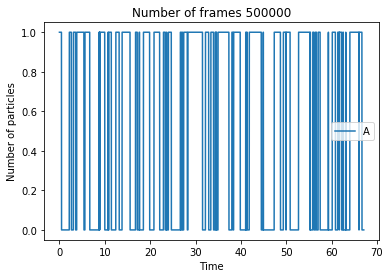

In [20]:
def plot_counts(counts, times, config):
    plt.plot(times, counts[:, config.types["A"]], label="A")
    #plt.plot(times, counts[:, config.types["B"]], label="B")
    #plot(lambda x: analytic_model_a(x, 2.), 
    #     times, label=r"true model $a(t) = \frac{a(0)}{1 + a(0)\, \kappa\, t}$")
    plt.legend(loc="best")
    plt.xlabel("Time")
    plt.ylabel("Number of particles")
    plt.title("Number of frames " + str(len(counts)))

plot_counts(counts, times, config)

## readdy_learn

In [21]:
counts = counts
times = times

In [24]:
# Trajectory object
import py_analyze_tools.tools as pat

traj = pat.Trajectory.from_counts(config, counts, times[1]-times[0])
traj.update()

# Basis functions
from py_analyze_tools.sklearn import BasisFunctionConfiguration

bfc = BasisFunctionConfiguration(n_species=traj.n_species)
bfc.add_conversion(0, 1) # A -> B
bfc.add_conversion(1, 0) # B -> A
right_rates = np.array([rate_1, rate_2])

# Estimate
from py_analyze_tools.sklearn import ReaDDyElasticNetEstimator

est = ReaDDyElasticNetEstimator(traj, bfc, 1., 
                                alpha=0., l1_ratio=1., method=None,
                                verbose=True, approx_jac=False, options={'ftol': 1e-12})
est.fit(None)
coefficients = est.coefficients_
print("coefficients=%s" % coefficients)
print("right rates =%s" % right_rates)

max counts = 1.0, min nonzero counts = 1.0
optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
4 / 15000 iterations
coefficients=[ 0.01388116  0.        ]
right rates =[ 1.  2.]


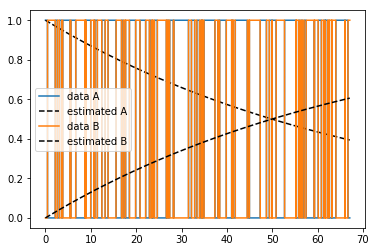

In [26]:
from scipy.integrate import odeint

def fun(data, _):
    theta = np.array([f(data) for f in bfc.functions])
    return np.matmul(coefficients, theta)

estimated_realisation = odeint(fun, traj.counts[0], np.arange(0., traj.n_time_steps*traj.time_step, traj.time_step))
for t in ["A", "B"]:
    type_id = config.types[t]
    plt.plot(times, traj.counts[:, type_id], label="data "+t)
    plt.plot(times, estimated_realisation[:, type_id], "k--", label="estimated "+t)
    plt.legend(loc="best")

plt.show()